#     Определение перспективного тарифа для телеком-компании

## Загрузка и изучение данных

In [1]:
import pandas as pd #импортируем библиотеки
import pathlib
from pathlib import Path
import matplotlib 
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
calls_path = Path(pathlib.Path.cwd(), "calls.csv")
calls = pd.read_csv(calls_path)

In [4]:
internet_path = Path(pathlib.Path.cwd(), "internet.csv")
internet = pd.read_csv(internet_path)

In [5]:
messages_path = Path(pathlib.Path.cwd(), "messages.csv")
messages = pd.read_csv(messages_path)

In [6]:
tariffs_path = Path(pathlib.Path.cwd(), "tariffs.csv")
tariffs = pd.read_csv(tariffs_path)

In [7]:
users_path = Path(pathlib.Path.cwd(), "users.csv")
users = pd.read_csv(users_path)

In [8]:
calls.info() # получим общую информацию о данных в таблице calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице "calls" 20267 строк, 4 столбца, пропусков нет.

In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В таблице "internet" 149396 строки, 5 столбцов, пропусков нет. 

In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В таблице "messages"  123036 строк, 3 столбца, пропусков нет 

In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В таблице "tariffs" 2 сторки, 8 столбцов, пропусков нет.

In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В таблице "users" 500 строк, 8 столбцов, пропусков нет.

## Подготовка данных

Все отлично, пропусков в данных нет. Объединим таблицы в одну последовательно по id

Сгруппируем таблицы по пользователям и месяцам:
1. Для этого сначала пребразуем строковые значения с датой в формат datetime:

In [13]:
calls['datetime'] = pd.to_datetime(calls['call_date'], format = '%Y.%m.%d')

In [14]:
calls['months'] = calls['datetime'].astype('datetime64[M]') # создаю столбец с месяцем - годом

In [15]:
calls.head(5)

,id,call_date,duration,user_id,datetime,months
0,1000_0,2018-07-25,0.00,1000,2018-07-25,2018-07-01
1,1000_1,2018-08-17,0.00,1000,2018-08-17,2018-08-01
2,1000_2,2018-06-11,2.85,1000,2018-06-11,2018-06-01
3,1000_3,2018-09-21,13.80,1000,2018-09-21,2018-09-01
4,1000_4,2018-12-15,5.18,1000,2018-12-15,2018-12-01


In [16]:
internet['datetime'] = pd.to_datetime(internet['session_date'], format = '%Y.%m.%d')

In [17]:
internet['months'] = internet['datetime'].astype('datetime64[M]')

In [18]:
messages['datetime'] = pd.to_datetime(messages['message_date'], format = '%Y.%m.%d')

In [19]:
messages['months'] = messages['datetime'].astype('datetime64[M]')

In [20]:
users = users.rename(columns = {'tariff': 'tariff_name'}) # в таблице users изменим столбец tariff на tariff_name

2. Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам

Для этого сгруппируем по месяцам и пользователям:

In [21]:
calls_pivot = calls.pivot_table(index = ['user_id','months'], values = 'duration', aggfunc = ['sum', 'count']).reset_index() 
# количество израсходованных минут по месяцам и количество звонков в месяц

In [22]:
calls_pivot.columns = ['user_id', 'months', 'calls_duration', 'calls_in_month']

In [23]:
calls_pivot.head(5)

,user_id,months,calls_duration,calls_in_month
0,1000,2018-05-01,150.06,22
1,1000,2018-06-01,158.90,43
2,1000,2018-07-01,318.80,47
3,1000,2018-08-01,389.87,52
4,1000,2018-09-01,440.14,58


Объединим эти таблицы с таблицей users по параметру user_id, получим количество израсходованных минут по месяцам для каждого пользоввателя (users_calls_pivot_duration): 

In [24]:
users_calls_pivot = users.merge(calls_pivot, on = 'user_id') 

Округлим длительность звонков в большую сторону, как требует тариф: 

In [25]:
users_calls_pivot['calls_duration'] = users_calls_pivot['calls_duration'].apply(np.ceil)

In [26]:
users_calls_pivot.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,months,calls_duration,calls_in_month
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01,151.0,22
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06-01,159.0,43
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07-01,319.0,47
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08-01,390.0,52
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09-01,441.0,58


Посчитаем количество отправленных сообщений пользователями по месяцам:

In [27]:
messages_pivot = messages.pivot_table(index = ['user_id', 'months'], values = 'id', aggfunc = 'count').reset_index()
# количество отправленных сообщений по месяцам;

In [28]:
messages_pivot.columns = ['user_id', 'months', 'sms'] # переименуем столбцы

In [29]:
messages_pivot.head(5)

,user_id,months,sms
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


Совместив с таблицей users по параметру user_id, получим количество отправленных сообщений по месяцам для каждого пользователя:

In [30]:
users_messages_pivot = users.merge(messages_pivot, on = 'user_id') 

In [31]:
users_messages_pivot.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,months,sms
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01,22
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06-01,60
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07-01,75
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08-01,81
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09-01,57


3. Посчитаем объем интернет трафика для каждого пользователя по месяцам:

In [32]:
internet_pivot = internet.pivot_table(index = ['user_id', 'months'], values = 'mb_used', aggfunc = 'sum').reset_index()
# объем израсходованного интернет-трафика по месяцам каждым пользователем

In [33]:
internet_pivot.columns = ['user_id', 'months', 'mb_sum']

In [34]:
internet_pivot['mb_sum'] = internet_pivot['mb_sum'].apply(np.ceil) # округлим до целого в большую сторону

In [35]:
internet_pivot.head(5)

,user_id,months,mb_sum
0,1000,2018-05-01,2254.0
1,1000,2018-06-01,23234.0
2,1000,2018-07-01,14004.0
3,1000,2018-08-01,14056.0
4,1000,2018-09-01,14569.0


Аналогично, совместив с таблицей users по параметру user_id, получим объем израсходованного интернет-трафика по месяцам каждым пользователем:

In [36]:
users_internet_pivot = users.merge(internet_pivot, on = 'user_id') 

In [37]:
users_internet_pivot.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,months,mb_sum
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01,2254.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06-01,23234.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07-01,14004.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08-01,14056.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09-01,14569.0


4. Посчитаем помесячную выручку с каждого пользователя: 

Склеим все в одно целое: 

In [38]:
df1 = calls_pivot.merge(messages_pivot, on = ['user_id', 'months'], how = 'outer') 
# склеим таблицы звонки и сообщения в одно по user_id и months

In [39]:
df2 = df1.merge(internet_pivot, on = ['user_id', 'months'], how = 'outer')
# далее добавим интернет трафик.

Получили таб где для каждого пользователя информация о длительности звонков, количестве звонков, количестве смс, количестве интернет трафика за месяц. 

In [40]:
df2.head(5)

,user_id,months,calls_duration,calls_in_month,sms,mb_sum
0,1000,2018-05-01,150.06,22.0,22.0,2254.0
1,1000,2018-06-01,158.90,43.0,60.0,23234.0
2,1000,2018-07-01,318.80,47.0,75.0,14004.0
3,1000,2018-08-01,389.87,52.0,81.0,14056.0
4,1000,2018-09-01,440.14,58.0,57.0,14569.0


Видим, что есть пропуски значений, т.е кто то из пользователей не совершал звонки, или не отправлял смс, или не серфил в интернете. Заменим эти пропуски нулями.

In [41]:
df2['calls_duration'] = df2['calls_duration'].fillna(0)

In [42]:
df2['calls_in_month'] = df2['calls_in_month'].fillna(0)

In [43]:
df2['sms'] = df2['sms'].fillna(0)

In [44]:
df2['mb_sum'] = df2['mb_sum'].fillna(0)

Склеим по user_id с таблицей users:

In [45]:
df_users = df2.merge(users, on = ['user_id'])

In [46]:
df_users.head(5)

,user_id,months,calls_duration,calls_in_month,sms,mb_sum,age,churn_date,city,first_name,last_name,reg_date,tariff_name
0,1000,2018-05-01,150.06,22.0,22.0,2254.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2018-06-01,158.90,43.0,60.0,23234.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,2018-07-01,318.80,47.0,75.0,14004.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,2018-08-01,389.87,52.0,81.0,14056.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,2018-09-01,440.14,58.0,57.0,14569.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Склеим полученную таблицу с таблицей tariffs: 

In [47]:
df_users_tariffs = df_users.merge(tariffs, on = 'tariff_name')

In [48]:
df_users_tariffs.head(5) # получили итоговую таблицу

,user_id,months,calls_duration,calls_in_month,sms,mb_sum,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,2018-05-01,150.06,22.0,22.0,2254.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,2018-06-01,158.90,43.0,60.0,23234.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,2018-07-01,318.80,47.0,75.0,14004.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,2018-08-01,389.87,52.0,81.0,14056.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,2018-09-01,440.14,58.0,57.0,14569.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [49]:
df_users_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   months                 3214 non-null   datetime64[ns]
 2   calls_duration         3214 non-null   float64       
 3   calls_in_month         3214 non-null   float64       
 4   sms                    3214 non-null   float64       
 5   mb_sum                 3214 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    object        
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   object        
 12  tariff_name            3214 non-null   object        
 13  mes

In [50]:
df_users_tariffs.duplicated().sum() # проверяем количество дубликатов

0

In [51]:
df_users_tariffs.head(5)

,user_id,months,calls_duration,calls_in_month,sms,mb_sum,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,2018-05-01,150.06,22.0,22.0,2254.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,2018-06-01,158.90,43.0,60.0,23234.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,2018-07-01,318.80,47.0,75.0,14004.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,2018-08-01,389.87,52.0,81.0,14056.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,2018-09-01,440.14,58.0,57.0,14569.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [52]:
def over_tariff(row):
    pay_calls = 0
    pay_sms = 0
    pay_internet = 0
    if row['calls_duration'] - row['minutes_included'] > 0:
        pay_calls = (row['calls_duration'] - row['minutes_included'])*row['rub_per_minute']
    if row['sms'] - row['messages_included'] > 0:
        pay_sms = (row['sms'] - row['messages_included'])*row['rub_per_message']
    if row['mb_sum'] - row['mb_per_month_included'] > 0:
        pay_internet = ((row['mb_sum'] - row['mb_per_month_included'])/1024)*row['rub_per_gb']
    return pay_calls + pay_sms + pay_internet


In [53]:
df_users_tariffs['pay'] = df_users_tariffs.apply(over_tariff, axis = 1) # перерасход

In [54]:
df_users_tariffs['pay'] = df_users_tariffs['pay'] + df_users_tariffs['rub_monthly_fee'] # итоговая плата каждого пользователя

In [55]:
df_users_tariffs['pay'] = np.around(df_users_tariffs['pay'], decimals = 0) # округлим плату до целых

In [56]:
# df_users_tariffs.set_option('display.max_columns', None)

In [57]:
df_users_tariffs.head(5)
# pd.set_option('display.max_columns', None)

,user_id,months,calls_duration,calls_in_month,sms,mb_sum,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,pay
0,1000,2018-05-01,150.06,22.0,22.0,2254.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
1,1000,2018-06-01,158.90,43.0,60.0,23234.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
2,1000,2018-07-01,318.80,47.0,75.0,14004.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
3,1000,2018-08-01,389.87,52.0,81.0,14056.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
4,1000,2018-09-01,440.14,58.0,57.0,14569.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0


## Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Определим сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

- Рассмотрим какова длительность звонков для каждого тарифа:

In [58]:
df_users_tariffs['calls_duration'].describe() # получим представление о выборке длительность разговоров

count    3214.000000
mean      425.883647
std       228.567566
min         0.000000
25%       267.360000
50%       417.875000
75%       555.030000
max      1578.060000
Name: calls_duration, dtype: float64

In [59]:
df_users_tariffs['tariff_name'].value_counts() # количество тарифов в таблице

smart    2229
ultra     985
Name: tariff_name, dtype: int64

Получим значения среднего, дисперсии и стандартного отклонения для длятельности звонков для каждого тарифа:

In [60]:
display(df_users_tariffs.groupby('tariff_name').agg({'calls_duration': ['mean','var','std']}))

calls_duration                          
                      mean           var         std
tariff_name                                         
smart           394.427026  32386.395979  179.962207
ultra           497.068223  89942.500370  299.904152

Для визуализации распределения количества минут разговора в каждом тарифе постоим "ящик с усам":

(0.0, 1600.0)

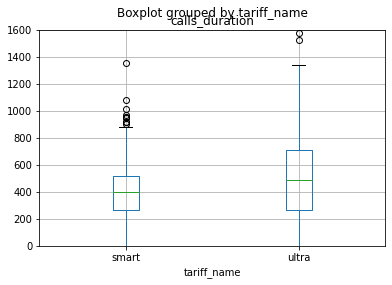

In [61]:
df_users_tariffs.boxplot('calls_duration', by = 'tariff_name')
plt.ylim(0, 1600)

Из графика видно,  что у пользователей тарифа "Ультра" разговоры более длительные. Пользователи тарифа "Смарт" чаще превышают 500 мин, ограниченные тарифом. 

Построим гистограмму в которой отображено количество звонков от длительности для каждого тарифа: 

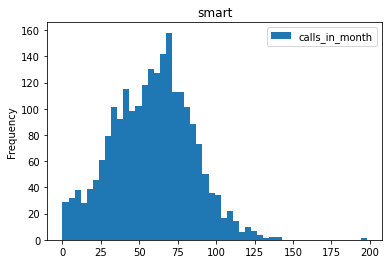

In [62]:
df_users_tariffs.query('tariff_name == "smart"').plot(x = 'calls_duration', y = 'calls_in_month', 
                                                      kind='hist', bins=50, title = 'smart')
plt.show()

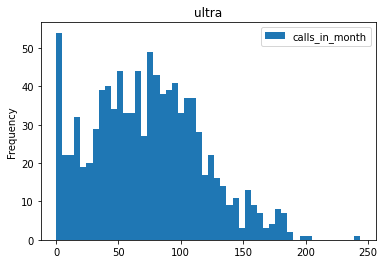

In [63]:
df_users_tariffs.query('tariff_name == "ultra"').plot(x = 'calls_duration', y = 'calls_in_month', 
                                                      kind='hist', bins=50, title = 'ultra')
plt.show()

Пользователи Смарта чаще совершают звонки по 70 мин, у пользователей Ультры максимум в районе 0, видимо это просто дозвоны с 0 продолжительностью. Количество более длинных звонков у пользователей Ультры больше. 

- Рассмотрим как распределено количество СМС от тарифа:

In [64]:
df_users_tariffs['sms'].describe()

count    3214.000000
mean       38.281269
std        36.148326
min         0.000000
25%         9.000000
50%        30.000000
75%        57.000000
max       224.000000
Name: sms, dtype: float64

Получим значения среднего, дисперсии и стандартного отклонения для количества СМС для каждого тарифа:

In [65]:
display(df_users_tariffs.groupby('tariff_name').agg({'sms': ['mean','var','std']}))

sms                        
                  mean          var        std
tariff_name                                   
smart        33.384029   796.812958  28.227876
ultra        49.363452  2285.266143  47.804457

(0.0, 300.0)

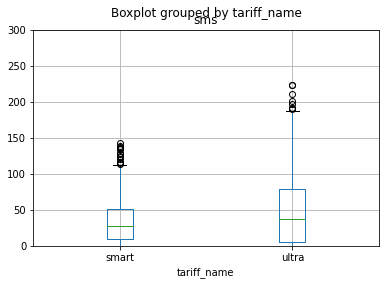

In [66]:
df_users_tariffs.boxplot('sms', by = 'tariff_name')
plt.ylim(0, 300)

Из графика видно, что пользователи тарифа "Смарт" также выходят за количество СМС, ограниченных в тарифе (50 сообщений в месяц). Пользователи "Ультры" не превысили ограниченния тарифа по количеству СМС. 


Рассмотрим, как распределено количество СМС в месяц для каждого тарифа:

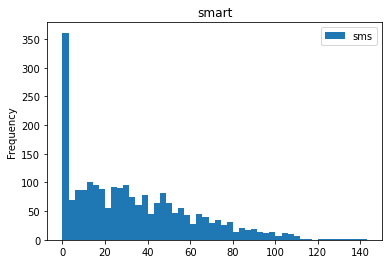

In [67]:
df_users_tariffs.query('tariff_name == "smart"').plot(y = 'sms', kind='hist', bins=50, title = 'smart')
plt.show()

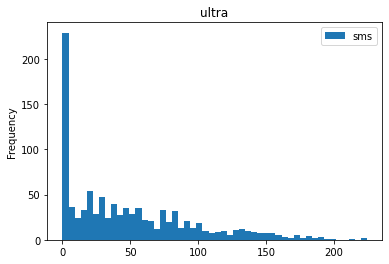

In [68]:
df_users_tariffs.query('tariff_name == "ultra"').plot(y = 'sms', kind='hist', bins=50, title = 'ultra')
plt.show()

Пользователи обоих тарифов часто не пользуются СМС сообщениями. Пользователи Смарта отправляют сообщения чаще, чем Ультры. 

- Рассмотрим как распределено количество интернет трафика от тарифа:

In [69]:
df_users_tariffs['mb_sum'].describe()

count     3214.000000
mean     17208.101742
std       7570.970783
min          0.000000
25%      12492.250000
50%      16943.500000
75%      21425.000000
max      49746.000000
Name: mb_sum, dtype: float64

Получим значения среднего, дисперсии и стандартного отклонения для количества СМС для каждого тарифа:

In [70]:
display(df_users_tariffs.groupby('tariff_name').agg({'mb_sum': ['mean','var','std']}))

mb_sum                            
                     mean           var           std
tariff_name                                          
smart        16208.872140  3.446256e+07   5870.482049
ultra        19469.302538  1.017514e+08  10087.190383

(0.0, 55000.0)

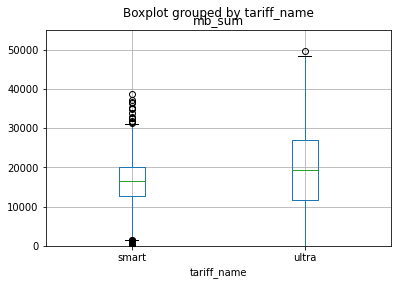

In [71]:
df_users_tariffs.boxplot('mb_sum', by = 'tariff_name')
plt.ylim(0, 55000)

Аналогично с количеством интернет трафика в каждом тарифе. Пользователи "Смарта" часто превышают 15 Гб, установленных тарифом. 

Рассмотрим, как распределено количество используемого трафика за месяц пользователями каждого тарифа:

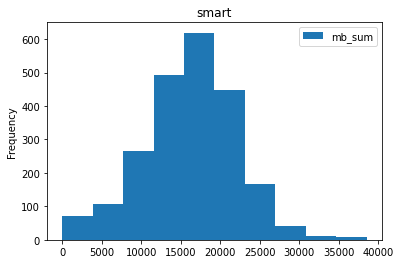

In [72]:
df_users_tariffs.query('tariff_name == "smart"').plot(y = 'mb_sum', kind='hist', bins=10, title = 'smart')
plt.show()

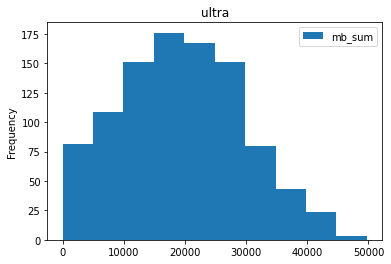

In [73]:
df_users_tariffs.query('tariff_name == "ultra"').plot(y = 'mb_sum', kind='hist', bins=10, title = 'ultra')
plt.show()

Пользователи Ультры используют больше трафика, однако количество пользователей Смарта больше. В Смарте пользователи выходят за пределы тарифа. 

## Проверка гипотез

 - Проверим гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

> Нулевая гипотеза (H0): средняя выручка пользователей тарифов Смарт и Ультра равна 

> Альтернативная гипотеза (H1): средняя выручка пользователей тарифов Смарт и Ультра различаются

Осуществим проверку двусторонней гипотезы: 

In [93]:
alpha = .05 # критический уровень средненстатистической значимости будем считать равным 0,05

In [75]:
display(df_users_tariffs.groupby('tariff_name').agg({'pay': ['mean','var','std']})) 
# вычислим среднее, дисперсию, стандартное отклонение для каждого тарифа

pay                           
                    mean            var         std
tariff_name                                        
smart        1197.684163  589282.073452  767.647102
ultra        2059.878173  125954.556281  354.900770

In [102]:
df_smart = df_users_tariffs.query('tariff_name == "smart"')['pay'] # массив выручка пользователей Смарта
df_ultra = df_users_tariffs.query('tariff_name == "ultra"')['pay'] # массив выручка пользователей Ультра

In [98]:
value_smart =  df_users_tariffs.query('tariff_name == "smart"').agg({'pay': 'mean'}) # средняя выручка пользователей Смарта
value_ultra =  df_users_tariffs.query('tariff_name == "ultra"').agg({'pay': 'mean'}) # средняя выручка пользователей Ультры

In [99]:
print("Средняя выручка тарифа Смарт", value_smart.astype('int'))
print("Средняя выручка тарифа Ультра", value_ultra.astype('int'))

Средняя выручка тарифа Смарт pay    1197
dtype: int32
Средняя выручка тарифа Ультра pay    2059
dtype: int32


In [103]:
result = st.ttest_1samp(df_ultra, value_smart)
print('p-значение:', result.pvalue)

p-значение: pay    0.0
dtype: float64


pay    0.0
dtype: float64

In [101]:
if result.pvalue < 0.05:
    
    print('Отвергаем гипотезу')
else: 
    print('Гипотеза верна')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

Кроме того, можно осуществить проверку гипотез методом сравнения средних двух генеральных совокупностей: 

In [80]:
result = st.ttest_ind(df_smart, df_ultra)
print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем гипотезу')
else: 
    print('Гипотеза верна')

p-значение: 2.274570891094426e-213
Отвергаем гипотезу


*Проверка двумя методами дала результат: отвергаем гипотезу о равенстве средней выручки пользователей тарифов Смарт и Ультра.*

- Проверим гипотезу: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевая гипотеза (H0): средняя выручка пользователей из Москвы равна выручке пользователей из других регионов 

Альтернативная гипотеза (H1): средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [81]:
df_users_tariffs['city'].unique() # список городов

array(['Краснодар', 'Москва', 'Новокузнецк', 'Иваново', 'Омск', 'Уфа',
       'Томск', 'Санкт-Петербург', 'Тверь', 'Ярославль', 'Тюмень',
       'Ростов-на-Дону', 'Калуга', 'Тула', 'Волгоград', 'Саранск',
       'Иркутск', 'Череповец', 'Новосибирск', 'Брянск', 'Тольятти',
       'Нижний Тагил', 'Воронеж', 'Махачкала', 'Пермь', 'Сургут', 'Пенза',
       'Мурманск', 'Набережные Челны', 'Самара', 'Нижний Новгород',
       'Кемерово', 'Кострома', 'Оренбург', 'Магнитогорск', 'Астрахань',
       'Нижневартовск', 'Челябинск', 'Курган', 'Красноярск',
       'Владивосток', 'Смоленск', 'Владимир', 'Казань', 'Саратов',
       'Севастополь', 'Рязань', 'Екатеринбург', 'Стерлитамак',
       'Ульяновск', 'Балашиха', 'Барнаул', 'Киров', 'Сочи', 'Вологда',
       'Чебоксары', 'Чита', 'Петрозаводск', 'Хабаровск', 'Ставрополь',
       'Улан-Удэ', 'Курск', 'Якутск', 'Химки', 'Владикавказ', 'Ижевск',
       'Орёл', 'Белгород', 'Архангельск', 'Липецк', 'Волжский', 'Тамбов',
       'Калининград', 'Новороссий

In [82]:
df_mosсow = df_users_tariffs.query('city == "Москва"')['pay']
df_regions = df_users_tariffs.query('city != "Москва"')['pay']

In [83]:
value_mosсow =  df_users_tariffs.query('city == "Москва"').agg({'pay': 'mean'})
value_regions =  df_users_tariffs.query('city != "Москва"').agg({'pay': 'mean'})

In [84]:
print("Средняя выручка в Москве", value_mosсow.astype('int'))
print("Средняя выручка в регионах", value_regions.astype('int'))

Средняя выручка в Москве pay    1485
dtype: int32
Средняя выручка в регионах pay    1456
dtype: int32


Осуществим проверку двусторонней гипотезы:

In [89]:
result = st.ttest_1samp(df_mosсow, value_regions)
print('p-значение:', result.pvalue)

p-значение: pay    0.336642
dtype: float64


In [90]:
if result.pvalue < alpha:
    print('Отвергаем гипотезу')
else: 
    print('Гипотеза верна')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

 Проверим гипотезу методом сравнения средних двух генеральных совокупностей: 

In [88]:
result = st.ttest_ind(df_mosсow, df_regions)
print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем гипотезу')
else: 
    print('Гипотеза верна')

p-значение: 0.41202466759638556
Гипотеза верна


*Проверка показала: гипотеза верна - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов*

## Общий вывод

1.	Открыли и подготовили данные. Произвели округления, преобразования типов данных, где это необходимо. Сгруппировали данные по месяцам и пользователям. Провели объединение таблиц. 
2.	Провели расчеты: 
 -	Посчитали количество сделанных звонков и израсходованных минут разговора каждого пользователя по месяцам. 
 -	Посчитали количество отправленных сообщений пользователями по месяцам. 
 -	Посчитали объем интернет трафика для каждого пользователя по месяцам
 -	Посчитали помесячную выручку с каждого пользователя
3.	Провели анализ полученных данных: 
 -	у пользователей тарифа "Ультра" разговоры более длительные. Пользователи тарифа "Смарт" чаще превышают 500 мин, ограниченные тарифом. Количество более длинных звонков у пользователей тарифа Ультра больше, но они не выходят за тарифный план. 
 -	пользователи тарифа "Смарт" выходят за количество СМС, ограниченных в тарифе (50 сообщений в месяц). Пользователи "Ультры" не превысили ограничения тарифа по количеству СМС. 
 - 	Пользователи "Смарта" часто превышают 15 Гб, установленных тарифом. Пользователи Ультры используют больше трафика, однако количество пользователей Смарта больше.
4.	В результате проверки гипотез установили, что  
 - 	средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. 
 - 	средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. 
